#### Outline
1. Data collection
2. Feature Engineering
3. Input Construction
4. GRU Modeling
5. GRU Model Evaluation

## 1. Data collection - Individual Stocks

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
ticker = "CBA"

df = pd.read_csv("combined_stock_data.csv", parse_dates=['Date'])
stock_df = df[df['Name'] == ticker].copy()

# Sort by date
stock_df.sort_values(by='Date', inplace=True)

# Set index
stock_df.set_index('Date', inplace=True)


# Missing values
print("\n Missing values:")
print(stock_df.isnull().sum())  # Count missing values per column
stock_df.dropna(inplace=True)

# Check column and head
print(stock_df.columns)
print(stock_df.head())

# Check the number of rows
freq_counts = stock_df['Name'].value_counts()
print(freq_counts.describe())


 Missing values:
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Name'], dtype='object')
                 Open       High        Low      Close   Volume Name
Date                                                                
2020-01-02  64.860162  65.209704  64.535007  64.933319  1416232  CBA
2020-01-03  65.819375  65.998211  65.234096  65.282867  1622784  CBA
2020-01-06  64.811385  64.933313  64.404942  64.843895  2129260  CBA
2020-01-07  65.697438  66.006332  65.177192  66.006332  2417468  CBA
2020-01-08  66.022597  66.046983  65.055261  65.762474  1719114  CBA
count       1.0
mean     1266.0
std         NaN
min      1266.0
25%      1266.0
50%      1266.0
75%      1266.0
max      1266.0
Name: count, dtype: float64


## 📊 2. Features Engineering

These features combine classic time series lags, trend indicators, momentum oscillators, and volatility metrics.  
Grouped below by functional type, they provide rich information for both interpretable models and deep learning models like GRU.

---

### 🕒 Lag Features  
Understand **short-term behavior** via lags and returns.

| Column Name     | Description |
|-----------------|-------------|
| **price_lag1**   | Closing price from 1 day ago – captures immediate price momentum |
| **price_lag2**   | Closing price from 2 days ago – extends short-term memory |
| **return_lag1**  | Percentage return from 1 day ago – normalized price change (%) |

---

### 📈 Trend Indicators  
Capture **trend direction and reversals** using SMA, EMA, and price deviation.

| Column Name     | Description |
|-----------------|-------------|
| **SMA_5**        | 5-day Simple Moving Average – short-term trend average |
| **SMA_20**       | 20-day Simple Moving Average – long-term trend reference |
| **EMA_20**       | 20-day Exponential Moving Average – reacts faster to recent prices |
| **norm_price**   | Price deviation (%) from 20-day MA – normalized position relative to trend |

---

### 🔄 Momentum Indicators  
Measure **momentum and overbought/oversold conditions** via RSI and MACD.

| Column Name     | Description |
|-----------------|-------------|
| **RSI_14**       | 14-day Relative Strength Index – momentum oscillator (0–100 scale). Overbought if >70, Oversold if <30 |
| **MACD**         | Moving Average Convergence Divergence – difference between EMA(12) and EMA(26), indicates momentum direction |
| **MACD_signal**  | 9-day EMA of MACD – signal line used for MACD crossover buy/sell decisions |

---

### 🌊 Volatility Features  
Quantify **volatility and risk** using standard deviation and volatility ratios.

| Column Name       | Description |
|-------------------|-------------|
| **roll_std5**      | 5-day rolling standard deviation – short-term volatility indicator |
| **volatility_5**   | Standard deviation of 5-day returns – recent volatility measure |
| **volatility_20**  | Standard deviation of 20-day returns – longer-term volatility context |
| **vol_ratio**      | Ratio of short-term to long-term volatility (`vol_5 / vol_20`) – reflects market stability shifts |


In [4]:
import numpy as np

In [5]:
# Compute daily returns as percentage change in closing price
stock_df['returns'] = stock_df['Close'].pct_change() * 100

# ------------------------------------------
# 🕒 Lag Features
# ------------------------------------------
stock_df['price_lag1'] = stock_df['Close'].shift(1)
stock_df['price_lag2'] = stock_df['Close'].shift(2)
stock_df['return_lag1'] = stock_df['returns'].shift(1)

# ------------------------------------------
# 📈 Trend Indicators
# ------------------------------------------
stock_df['SMA_5'] = stock_df['Close'].rolling(window=5).mean()
stock_df['SMA_20'] = stock_df['Close'].rolling(window=20).mean()
stock_df['EMA_20'] = stock_df['Close'].ewm(span=20, adjust=False).mean()
stock_df['norm_price'] = (stock_df['Close'] - stock_df['SMA_20']) / stock_df['SMA_20'] * 100

# ------------------------------------------
# 🔄 Momentum Indicators
# ------------------------------------------

# RSI (14-day)
delta = stock_df['Close'].diff()
gain = (delta.where(delta > 0, 0)).fillna(0)
loss = (-delta.where(delta < 0, 0)).fillna(0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
stock_df['RSI_14'] = 100 - (100 / (1 + rs))

# MACD and Signal Line
ema_12 = stock_df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = stock_df['Close'].ewm(span=26, adjust=False).mean()
stock_df['MACD'] = ema_12 - ema_26
stock_df['MACD_signal'] = stock_df['MACD'].ewm(span=9, adjust=False).mean()

# ------------------------------------------
# 🌊 Volatility Features
# ------------------------------------------
stock_df['roll_std5'] = stock_df['Close'].rolling(window=5).std()
stock_df['volatility_5'] = stock_df['returns'].rolling(window=5).std()
stock_df['volatility_20'] = stock_df['returns'].rolling(window=20).std()
stock_df['vol_ratio'] = stock_df['volatility_5'] / stock_df['volatility_20'].replace(0, np.nan)

In [6]:
# Missing values
print("\n Missing values:")
print(stock_df.isnull().sum())


 Missing values:
Open              0
High              0
Low               0
Close             0
Volume            0
Name              0
returns           1
price_lag1        1
price_lag2        2
return_lag1       2
SMA_5             4
SMA_20           19
EMA_20            0
norm_price       19
RSI_14           13
MACD              0
MACD_signal       0
roll_std5         4
volatility_5      5
volatility_20    20
vol_ratio        20
dtype: int64


It's normal for rolling and shift-based indicators to have NaN values in the initial rows, since they require **past data** to compute.

Especially for models like GRU or CNN where the sequence order is important,
it's common practice to **drop** those initial rows with missing values before training the model.

In [7]:
stock_df.dropna(inplace=True)
print("Final shape after dropping NaNs:", stock_df.shape)

Final shape after dropping NaNs: (1246, 21)


In [8]:
import matplotlib.pyplot as plt

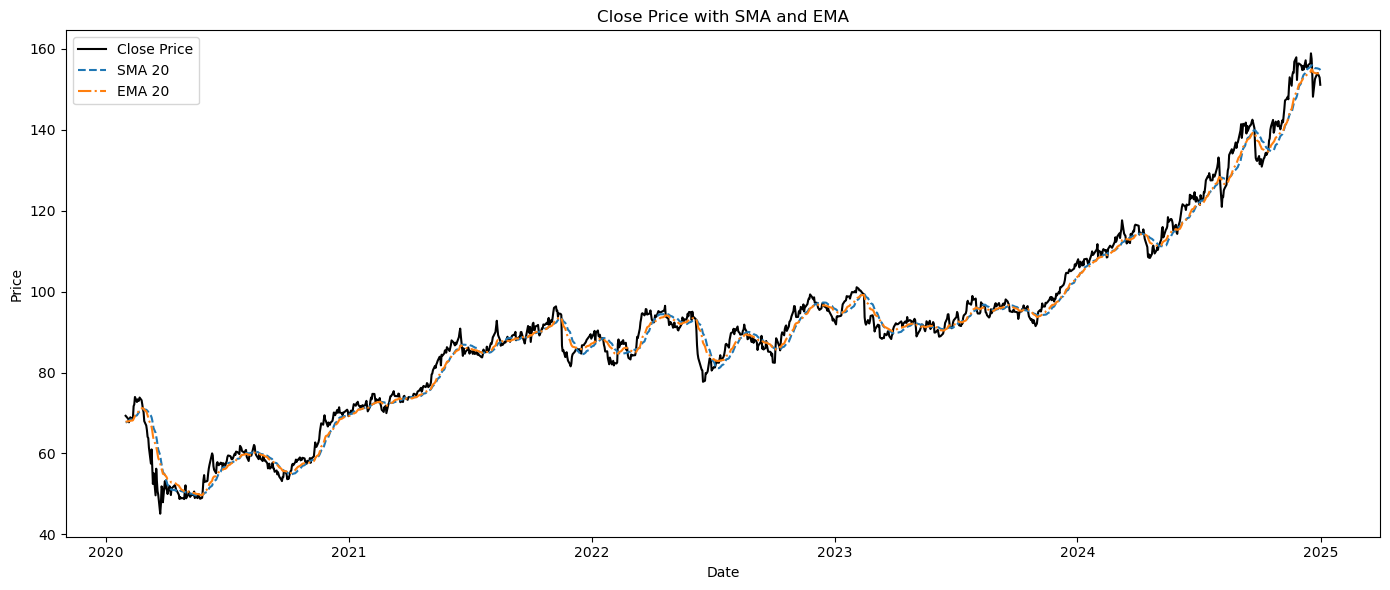

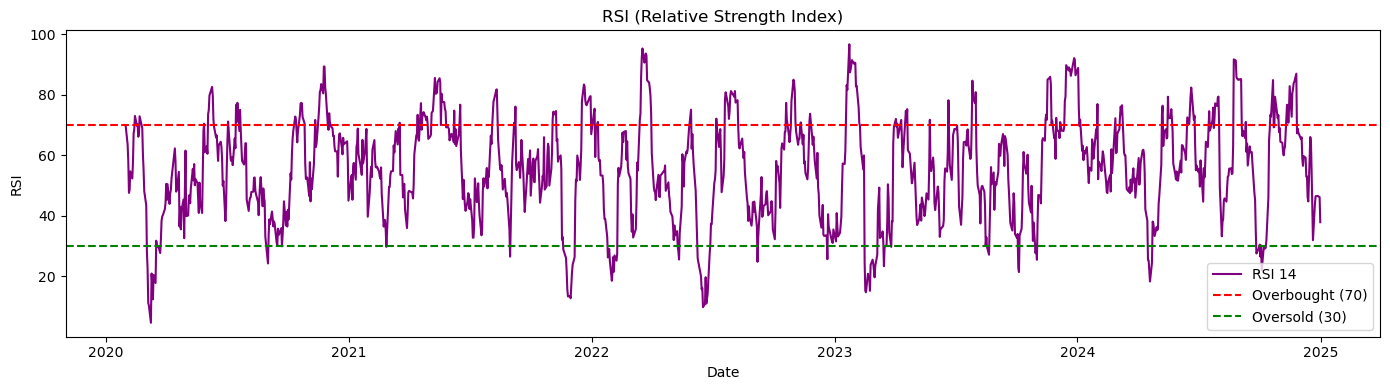

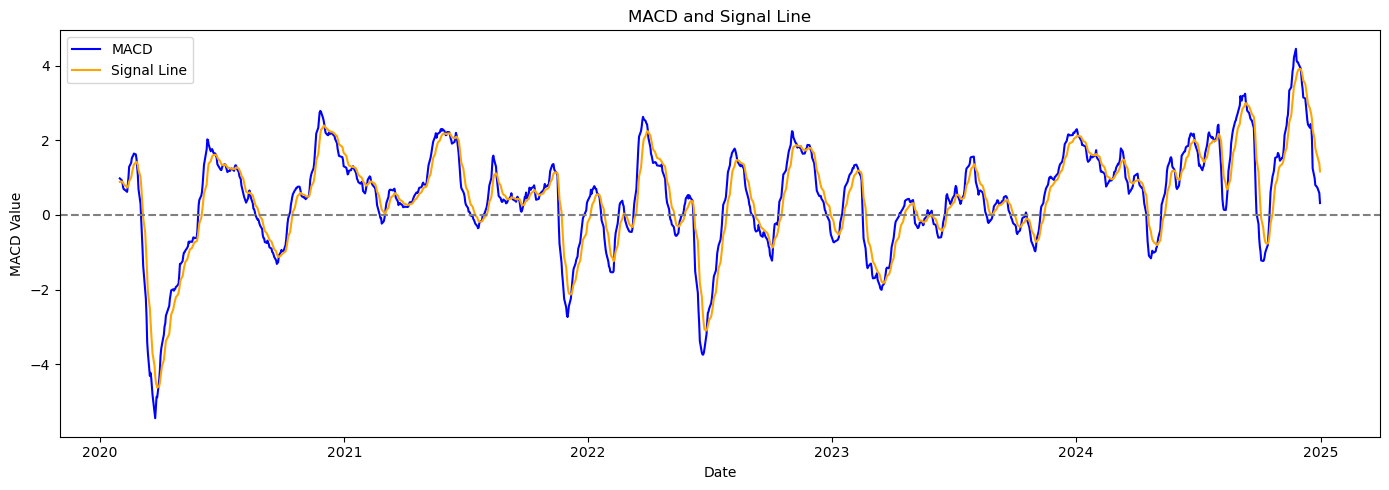

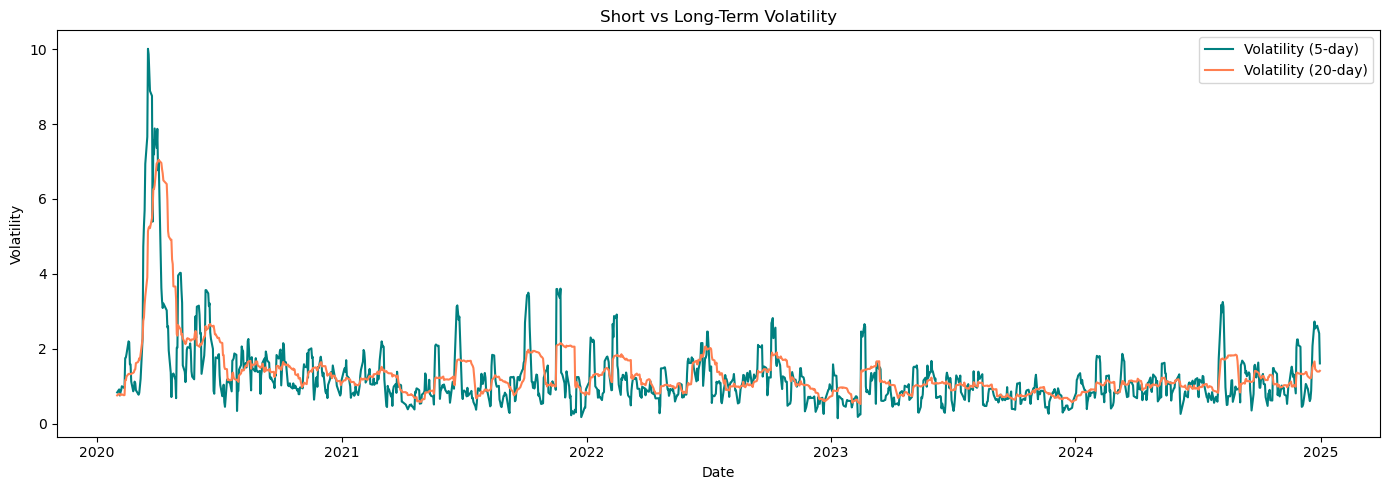

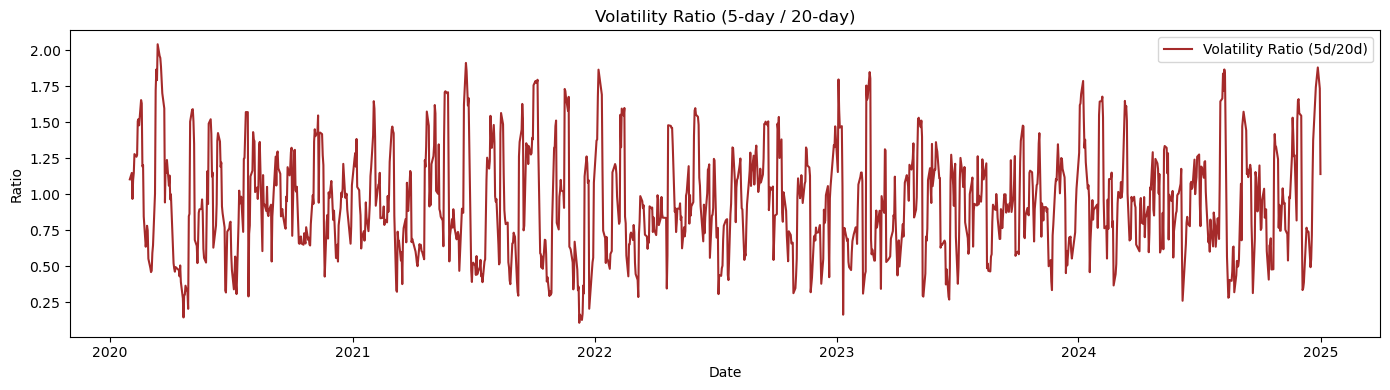

In [9]:
# ----------------------------------------
# 1. Price with SMA & EMA - Helps identify short- and long-term trend movements
# ----------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(stock_df['Close'], label='Close Price', color='black')
plt.plot(stock_df['SMA_20'], label='SMA 20', linestyle='--')
plt.plot(stock_df['EMA_20'], label='EMA 20', linestyle='-.')
plt.title('Close Price with SMA and EMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------------------
# 2. RSI - Detects potential overbought and oversold conditions for timing entries/exits
# ----------------------------------------
plt.figure(figsize=(14, 4))
plt.plot(stock_df['RSI_14'], label='RSI 14', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('RSI (Relative Strength Index)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------------------
# 3. MACD - Highlights possible trend reversal signals through line crossovers
# ----------------------------------------
plt.figure(figsize=(14, 5))
plt.plot(stock_df['MACD'], label='MACD', color='blue')
plt.plot(stock_df['MACD_signal'], label='Signal Line', color='orange')
plt.axhline(0, color='gray', linestyle='--')
plt.title('MACD and Signal Line')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------------------
# 4. Volatility: rolling std and volatility ratio - Reveals market instability and periods of sharp fluctuations
# ----------------------------------------
plt.figure(figsize=(14, 5))
plt.plot(stock_df['volatility_5'], label='Volatility (5-day)', color='teal')
plt.plot(stock_df['volatility_20'], label='Volatility (20-day)', color='coral')
plt.title('Short vs Long-Term Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(stock_df['vol_ratio'], label='Volatility Ratio (5d/20d)', color='brown')
plt.title('Volatility Ratio (5-day / 20-day)')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.legend()
plt.tight_layout()
plt.show()

#### 📊 Interpretation of Technical Indicator Visualizations

---

**📈 1. Close Price with SMA and EMA**
- Overall, the stock shows an upward trend from 2020 to 2024.
- The SMA and EMA lines closely follow each other. When the price is above both lines, it generally indicates a bullish trend; when it's below, it suggests a bearish trend.

---

**🔄 2. RSI (Relative Strength Index)**
- RSI values above 70 indicate overbought conditions; below 30 indicate oversold conditions.
- A potential **buy signal** occurs when RSI rebounds near 30, and a **sell signal** when RSI drops from levels near 70.

---

**💡 3. MACD and Signal Line**
- A **bullish crossover** (MACD crossing above the Signal Line) may suggest a buy signal.
- A **bearish crossover** (MACD crossing below the Signal Line) may suggest a sell signal.
- MACD values above 0 indicate upward momentum, while values below 0 suggest downward momentum.

---

**🌊 4. Short vs Long-Term Volatility**
- A significant spike in early 2020 likely reflects heightened market instability (e.g., COVID-19 impact).
- Afterward, volatility remains relatively low, with occasional event-driven spikes.

---

**📊 5. Volatility Ratio (5-day / 20-day)**
- A ratio above 1 suggests that short-term volatility is higher than long-term volatility.
- Spikes near 2.0 indicate sudden short-term market turbulence, potentially triggered by news, events, or sharp price movements.
- Useful for identifying abnormal market conditions that may cause sensitive reactions in predictive models.


## 3. Input Construction

### Objective
Use the past **N day** of time-series as input **X**, and predict either the **closing price D days ahead** or the **price direction (up/down)** as output **Y**.

### Example Setting
- `N = 30`: Use the past 30 days of data as input
- `D = 5`: Predict the closing price (or direction) 5 days into the future

### Required Features
To construct effective input sequences, we include the following engineered features:

- Lag-based prices and returns: `price_lag1`, `return_lag1`, etc.
- Trend indicators: `SMA_5`, `EMA_20`, `norm_price`
- Momentum indicators: `RSI_14`, `MACD`, `MACD_signal`
- Volatility metrics: `volatility_5`, `vol_ratio`

The features are normalized or scaled where necessary to ensure stability in model training.

In [10]:
def create_sequences(data, target_col, N=30, D=5, task='regression'):
    """
    Create input-output sequences for time-series models like GRU or CNN.

    Parameters:
    - data: pandas DataFrame with time-series features
    - target_col: column name to be predicted (e.g., 'Close')
    - N: number of days to use as input (sequence length)
    - D: number of days ahead to predict
    - task: 'regression' or 'classification'

    Returns:
    - X: 3D numpy array (samples, N, features)
    - y: 1D or 2D numpy array of targets
    """

    X = []
    y = []

    features = data.drop(columns=[target_col]).values
    target = data[target_col].values

    for i in range(len(data) - N - D + 1):
        X_seq = features[i:i+N]
        if task == 'regression':
            y_label = target[i+N+D-1]  # Predict D days ahead closing price
        elif task == 'classification':
            y_label = 1 if target[i+N+D-1] > target[i+N-1] else 0  # Price up or down
        else:
            raise ValueError("Task must be 'regression' or 'classification'")

        X.append(X_seq)
        y.append(y_label)

    return np.array(X), np.array(y)

Ensure that only historical data is used to predict future values, in line with the principle of time series forecasting.
- **X**: The past **N days** of input data (e.g., from index `i` to `i+N-1`, representing up to time **t**
- **y**: The target value at **D days after** the input window (i.e., at index `i+N+D-1`), representing a **future time step to be predicted**

In [11]:
feature_cols = ['Volume', 'Open', 'High', 'Low', 
    'price_lag1', 'price_lag2', 'return_lag1',
    'SMA_5', 'SMA_20', 'EMA_20', 'norm_price',
    'RSI_14', 'MACD', 'MACD_signal',
    'volatility_5', 'volatility_20', 'vol_ratio'
]

target_col = 'Close'  # For regression
seq_df = stock_df[feature_cols + [target_col]].dropna().copy()

# Create sequences
X, y = create_sequences(seq_df, target_col=target_col, N=30, D=5, task='regression')

print("✅ Sequences created:")
print("X shape:", X.shape)  # (samples, 30, features)
print("y shape:", y.shape)  # (samples,)

✅ Sequences created:
X shape: (1212, 30, 17)
y shape: (1212,)


## 4. GRU Modeling

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

### Data Preprocessing

In [13]:
# Feature scaling (optional but recommended for GRU)
X_reshaped = X.reshape(-1, X.shape[-1])  # (1212*30, 13)
X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(X.shape)  # (1212, 30, 13)

# y scaling (for regression)
y = y.reshape(-1, 1)
y_scaler = MinMaxScaler()
y_scaler.fit(y)  # fit only once
y_scaled = y_scaler.transform(y)  # transform separately

### Train/Validation Split for Time Series

In [14]:
split_index = int(len(X_scaled) * 0.8)

# Training set: the first 80% of the sequence
X_train = X_scaled[:split_index]
y_train = y_scaled[:split_index]

# Validation set: the most recent 20%
X_val = X_scaled[split_index:]
y_val = y_scaled[split_index:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

X_train shape: (969, 30, 17)
X_val shape: (243, 30, 17)


- The temporal sequence must not be broken.
- **Using recent data as validation** allows us to test how the model would behave on unseen, future-like data.
- Once the model architecture is reasonably finaised, expand to **TimeSeriesSplit** for evaluating performance stability and implementing cross-validated GRU training.

### Build GRU model

In [15]:
# Set input dimensions
timesteps = X_train.shape[1]  # ➜ 30 (N-day input window)
features = X_train.shape[2]   # ➜ 13 (number of input features per time step)

# Build GRU model
gru_model = Sequential([
    GRU(64, input_shape=(timesteps, features), return_sequences=False), # Encodes the input sequence into a 64-dimensional representation
    Dropout(0.2), # Randomly drops a portion of the units during training to prevent overfitting
    Dense(32, activation='relu'), # Fully connected layer
    Dense(1)  # Regression output
])

gru_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

gru_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                15936     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 18049 (70.50 KB)
Trainable params: 18049 (70.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train GRU model

- `loss`: Mean Squared Error (MSE) on the training set  
- `val_loss`: Mean Squared Error (MSE) on the validation set

**🧠 Interpretation Guide**

| Pattern                | Interpretation                                                                 |
|------------------------|---------------------------------------------------------------------------------|
| `loss ↓`, `val_loss ↓` | The model is learning well and improving over time                            |
| `loss ↓`, `val_loss ↑` | Possible overfitting – the model fits training data well but does not generalize  |
| `loss ≈ val_loss`, high values | Stable learning but performance still has room for improvement               |


**✅ MAE (Mean Absolute Error)**

If `metrics=['mae']` is specified during model compilation,  
then `val_mae` represents the **average absolute difference** between predicted and actual values on the validation set.

**📈 Predicted vs Actual Plot Patterns**

| Pattern                                  | Interpretation                                                              |
|------------------------------------------|------------------------------------------------------------------------------|
| Lines closely overlap                    | Strong prediction performance                                             |
| Trend is correct but scale is off       | Scaling or normalization might need adjustment                             |
| Predictions are flat or unresponsive     | Model may be too simple or input sequence too short                        |
| Predictions fluctuate excessively        | Possible overfitting or noisy data                                          |


In [16]:
history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


31/31 [==============================] - 3s 27ms/step - loss: 0.0231 - mae: 0.1145 - val_loss: 0.0148 - val_mae: 0.1037
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0044 - mae: 0.0525 - val_loss: 0.0065 - val_mae: 0.0690
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0026 - mae: 0.0398 - val_loss: 0.0044 - val_mae: 0.0559
Epoch 4/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0019 - mae: 0.0334 - val_loss: 0.0038 - val_mae: 0.0515
Epoch 5/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0018 - mae: 0.0331 - val_loss: 0.0053 - val_mae: 0.0632
Epoch 6/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0016 - mae: 0.0312 - val_loss: 0.0058 - val_mae: 0.0660
Epoch 7/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0014 - mae: 0.0290 - val_loss: 0.0061 - val_mae: 0.0689
Epoch 8/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0012 - m

### Prediction and Visualisation
*The model trains on normalised data above, while interpretation is done on the original scale.*

*Make sure to use `X` and `y` generated after `.dropna()`, as mismatched lengths between `y_val` and `y_pred` can cause errors.*

*To zoom in, we can plot a subset like `plt.plot(y_val[:100])` for better visual clarity.*

In [17]:
# Predict
gru_y_pred = gru_model.predict(X_val)

# Inverse transform
gru_y_pred = y_scaler.inverse_transform(gru_y_pred)
gru_y_val = y_scaler.inverse_transform(y_val)

gru_index = stock_df.index[-len(gru_y_val):]

8/8 [==============================] - 0s 3ms/step


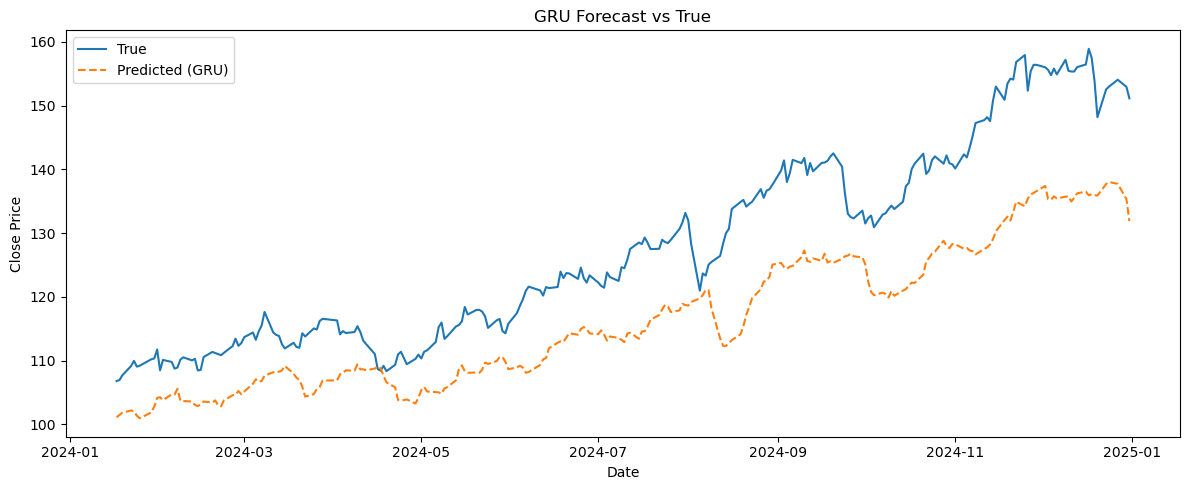

In [18]:
# Visualise
plt.figure(figsize=(12, 5))
plt.plot(gru_index, gru_y_val, label='True')
plt.plot(gru_index, gru_y_pred, label='Predicted (GRU)', linestyle='--')
plt.title('GRU Forecast vs True')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

| Aspect               | Insight |
|----------------------|---------|
| 📈 **Trend alignment** | The predicted line follows the general upward/downward trends of the true prices → indicates the model has learned directional dynamics well |
| 🔻 **Undershooting**   | The predicted values are consistently lower than the actual prices → might suggest bias or underfitting |
| ⚖️ **Smoothness**       | Predictions are smoother than actuals → typical of neural networks minimizing MSE |

To improve: 
- Try deeper GRU layers
- Include more predictive features
- Experiment with post-processing (e.g., rescaling or boosting techniques)

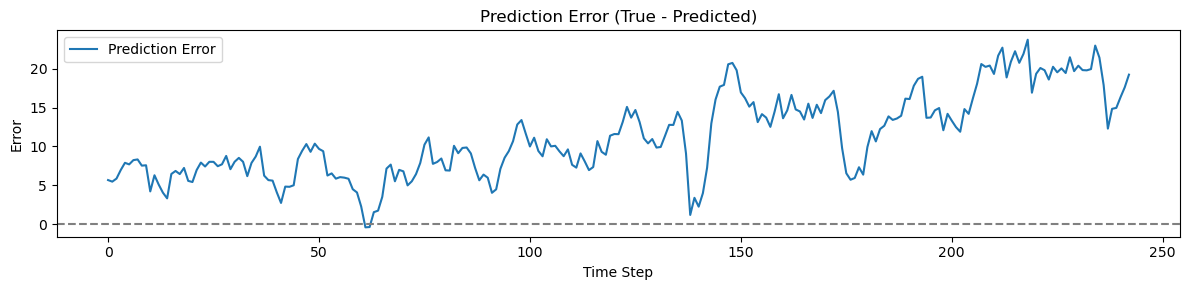

In [19]:
plt.figure(figsize=(12, 3))
plt.plot(gru_y_val - gru_y_pred, label='Prediction Error')
plt.title('Prediction Error (True - Predicted)')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

## 5. GRU Model Evaluation

### 5-1. Quantitative Evaluation
*While we've already reviewed common metrics like **loss, MAE, and val_loss**, it's helpful to include additional evaluation metrics to get a more complete picture of model performance.*

- **RMSE (Root Mean Squared Error)**: Measures the square root of the average squared difference between predicted and actual values. Penalizes large errors more heavily. A lower RMSE indicates better model accuracy.
- **MAPE (Mean Absolute Percentage Error)**: Expresses prediction error as a percentage of the actual values. It shows, on average, how far off the predictions are in relative terms. Lower is better.
- **$R^2$ Score (Coefficient of Determination)**: Represents how well the model explains the variance in the target variable. Ranges from 0 to 1 (closer to 1 is better). A negative value means the model performs worse than a horizontal line (mean predictor).

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [21]:
gru_rmse = np.sqrt(mean_squared_error(gru_y_val, gru_y_pred))
gru_mae = mean_absolute_error(gru_y_val, gru_y_pred)
gru_mape = mean_absolute_percentage_error(gru_y_val, gru_y_pred)
gru_r2 = r2_score(gru_y_val, gru_y_pred)

print("📊 GRU Performance:")
print(f"RMSE: {gru_rmse:.4f}")
print(f"MAE: {gru_mae:.4f}")
print(f"MAPE: {gru_mape:.4%}")
print(f"R² Score: {gru_r2:.4f}")

📊 GRU Performance:
RMSE: 12.4425
MAE: 11.2482
MAPE: 8.5051%
R² Score: 0.3209


The basic GRU captures overall price trends but still shows signs of **underfitting**. While it models the directional pattern, it lacks precision in predicting exact values.

**🛠️ Potential Directions for Model Improvement**

| Direction              | Description |
|------------------------|-------------|
| 🔁 **Model Architecture Tuning** | Try deeper GRU layers, increase hidden size, or adjust dropout rates |
| ➕ **Feature Expansion**          | Add more technical indicators or market-related variables (e.g., volume change rate, Bollinger Bands) |
| 🔍 **Hyperparameter Tuning**     | Optimize learning rate, batch size, sequence length, etc. |
| 🔀 **Hybrid Architectures**      | Explore GRU combined with Attention mechanisms or CNN-GRU hybrid models |
| 🔧 **Target Variable Adjustment**| Instead of predicting absolute price, consider forecasting price changes or direction (i.e., classification) |


### 5-2. Model Enhancements 

- 🔁 **Stacked GRU**: Enables deeper learning of temporal patterns by stacking multiple GRU layers.
- 🔀 **CNN+GRU Hybrid**: Use CNN layers to extract local features, followed by GRU to model sequential dependencies.
- 🔬 **Hyperparameter Tuning**: Experiment with different values for hidden size, dropout rate, learning rate, and other training parameters.

- GRU_model: GRU(64) ➝ Dropout ➝ Dense(32, relu) ➝ Dense(1)
    - In a single-layer GRU architecture, Dense(32, relu) layer helps enhance the model's ability to capture nonlinear feature interactions.
- Stacked_GRU_model: GRU(64, return_sequences=True) ➝ GRU(32) ➝ Dropout ➝ Dense(1)
    - The two GRU layers themselves already handle complex nonlinear transformations effectively.

In [22]:
# Feature scaling 
X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(X.shape)  # (1212, 30, 13)

# y scaling (for regression)
y_scaler = MinMaxScaler()
y_scaler.fit(y)  # fit only once
y_scaled = y_scaler.transform(y)  # transform separately

In [23]:
split_index = int(len(X_scaled) * 0.8)

# Training set: the first 80% of the sequence
X_train = X_scaled[:split_index]
y_train = y_scaled[:split_index]

# Validation set: the most recent 20%
X_val = X_scaled[split_index:]
y_val = y_scaled[split_index:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

X_train shape: (969, 30, 17)
X_val shape: (243, 30, 17)


In [24]:
# Set input dimensions
timesteps = X_train.shape[1]  # ➜ 30 (N-day input window)
features = X_train.shape[2]   # ➜ 13 (number of input features per time step)

# Build Stacked GRU model
stacked_gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(timesteps, features)),  # First GRU layer returns full sequence
    GRU(32),  # Second GRU layer processes the sequence summary
    Dropout(0.2),
    Dense(1)
])

# Compile
stacked_gru_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Summary
stacked_gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 30, 64)            15936     
                                                                 
 gru_2 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 25377 (99.13 KB)
Trainable params: 25377 (99.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# Train
history = stacked_gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
31/31 [==============================] - 5s 42ms/step - loss: 0.0272 - mae: 0.1237 - val_loss: 0.0032 - val_mae: 0.0480
Epoch 2/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0043 - mae: 0.0521 - val_loss: 0.0013 - val_mae: 0.0273
Epoch 3/50
31/31 [==============================] - 1s 16ms/step - loss: 0.0028 - mae: 0.0417 - val_loss: 0.0015 - val_mae: 0.0296
Epoch 4/50
31/31 [==============================] - 1s 16ms/step - loss: 0.0025 - mae: 0.0397 - val_loss: 0.0040 - val_mae: 0.0534
Epoch 5/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0025 - mae: 0.0382 - val_loss: 0.0061 - val_mae: 0.0681
Epoch 6/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0021 - mae: 0.0358 - val_loss: 0.0018 - val_mae: 0.0340
Epoch 7/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0020 - mae: 0.0349 - val_loss: 0.0038 - val_mae: 0.0527
Epoch 8/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0018 - m

In [26]:
# Predict
stacked_y_pred = stacked_gru_model.predict(X_val)

# Inverse transform
stacked_y_pred = y_scaler.inverse_transform(stacked_y_pred)
stacked_y_val = y_scaler.inverse_transform(y_val)

stacked_index = stock_df.index[-len(stacked_y_val):]

8/8 [==============================] - 1s 4ms/step


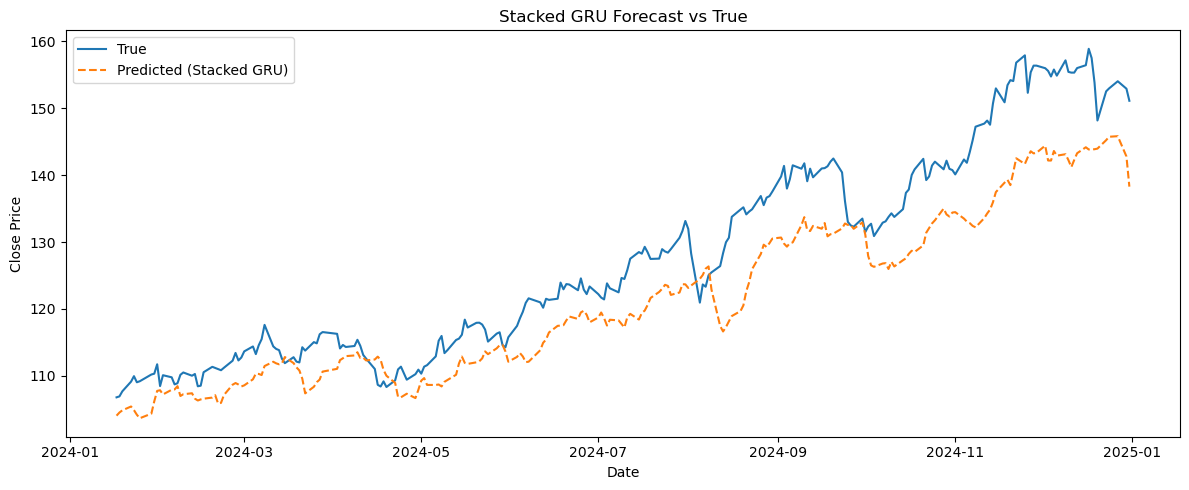

In [27]:
# Visualise
plt.figure(figsize=(12, 5))
plt.plot(stacked_index, stacked_y_val, label='True')
plt.plot(stacked_index, stacked_y_pred, label='Predicted (Stacked GRU)', linestyle='--')
plt.title('Stacked GRU Forecast vs True')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

stacked_gru_rmse = np.sqrt(mean_squared_error(stacked_y_val, stacked_y_pred))
stacked_gru_mae = mean_absolute_error(stacked_y_val, stacked_y_pred)
stacked_gru_mape = mean_absolute_percentage_error(stacked_y_val, stacked_y_pred)
stacked_gru_r2 = r2_score(stacked_y_val, stacked_y_pred)

print("📊 Stacked GRU Performance:")
print(f"RMSE: {stacked_gru_rmse:.4f}")
print(f"MAE: {stacked_gru_mae:.4f}")
print(f"MAPE: {stacked_gru_mape:.4%}")
print(f"R² Score: {stacked_gru_r2:.4f}")

📊 Stacked GRU Performance:
RMSE: 7.6508
MAE: 6.4955
MAPE: 4.8651%
R² Score: 0.7432


The stacked GRU significantly outperforms the basic GRU across all metrics.  
Thanks to its deeper structure, it can **learn more complex temporal patterns**, making it more reliable for time-series forecasting.

In [29]:
# Feature scaling 
X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(X.shape)  # (1212, 30, 13)

# y scaling (for regression)
y_scaler = MinMaxScaler()
y_scaler.fit(y)  # fit only once
y_scaled = y_scaler.transform(y)  # transform separately

In [30]:
split_index = int(len(X_scaled) * 0.8)

# Training set: the first 80% of the sequence
X_train = X_scaled[:split_index]
y_train = y_scaled[:split_index]

# Validation set: the most recent 20%
X_val = X_scaled[split_index:]
y_val = y_scaled[split_index:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

X_train shape: (969, 30, 17)
X_val shape: (243, 30, 17)


In [31]:
# Set input dimensions
timesteps = X_train.shape[1]  # ➜ 30 (N-day input window)
features = X_train.shape[2]   # ➜ 13 (number of input features per time step)

deep_gru_model = Sequential([
    GRU(128, return_sequences=True, input_shape=(timesteps, features)),
    Dropout(0.2),
    GRU(64, return_sequences=True),
    Dropout(0.2),
    GRU(32), 
    Dense(1)
])

deep_gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
deep_gru_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 30, 128)           56448     
                                                                 
 dropout_2 (Dropout)         (None, 30, 128)           0         
                                                                 
 gru_4 (GRU)                 (None, 30, 64)            37248     
                                                                 
 dropout_3 (Dropout)         (None, 30, 64)            0         
                                                                 
 gru_5 (GRU)                 (None, 32)                9408      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 103137 (402.88 KB)
Trainable params: 10

In [32]:
# Train the model
deep_gru_history = deep_gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
31/31 [==============================] - 7s 65ms/step - loss: 0.0166 - mae: 0.0943 - val_loss: 0.0103 - val_mae: 0.0896
Epoch 2/50
31/31 [==============================] - 1s 27ms/step - loss: 0.0020 - mae: 0.0349 - val_loss: 0.0139 - val_mae: 0.1068
Epoch 3/50
31/31 [==============================] - 1s 28ms/step - loss: 0.0014 - mae: 0.0289 - val_loss: 0.0108 - val_mae: 0.0920
Epoch 4/50
31/31 [==============================] - 1s 30ms/step - loss: 0.0013 - mae: 0.0284 - val_loss: 0.0072 - val_mae: 0.0720
Epoch 5/50
31/31 [==============================] - 1s 28ms/step - loss: 0.0011 - mae: 0.0264 - val_loss: 0.0109 - val_mae: 0.0922
Epoch 6/50
31/31 [==============================] - 1s 25ms/step - loss: 0.0012 - mae: 0.0266 - val_loss: 0.0073 - val_mae: 0.0720
Epoch 7/50
31/31 [==============================] - 1s 25ms/step - loss: 0.0010 - mae: 0.0249 - val_loss: 0.0061 - val_mae: 0.0641
Epoch 8/50
31/31 [==============================] - 1s 27ms/step - loss: 9.3160e-04

In [33]:
# Predict and inverse scale
deep_y_pred = deep_gru_model.predict(X_val)
deep_y_pred = y_scaler.inverse_transform(deep_y_pred)
deep_y_val = y_scaler.inverse_transform(y_val)

deep_index = stock_df.index[-len(deep_y_val):]

8/8 [==============================] - 1s 6ms/step


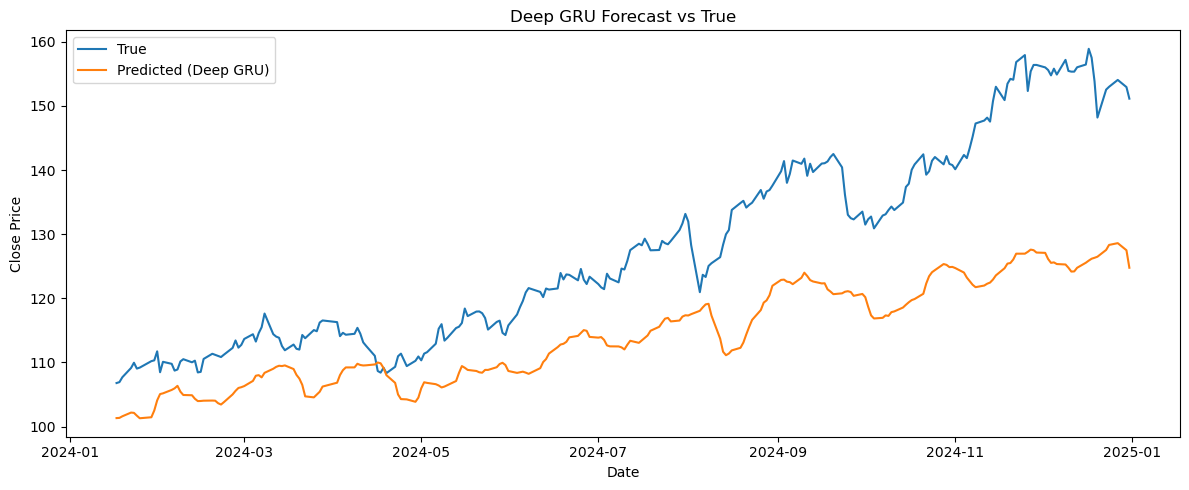

In [34]:
# Plotting
plt.figure(figsize=(12, 5))
plt.plot(deep_index, deep_y_val, label='True')
plt.plot(deep_index, deep_y_pred, label='Predicted (Deep GRU)')
plt.title('Deep GRU Forecast vs True')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

deep_gru_rmse = np.sqrt(mean_squared_error(deep_y_val, deep_y_pred))
deep_gru_mae = mean_absolute_error(deep_y_val, deep_y_pred)
deep_gru_mape = mean_absolute_percentage_error(deep_y_val, deep_y_pred)
deep_gru_r2 = r2_score(deep_y_val, deep_y_pred)

print("📊 Deep GRU Performance:")
print(f"RMSE: {deep_gru_rmse:.4f}")
print(f"MAE: {deep_gru_mae:.4f}")
print(f"MAPE: {deep_gru_mape:.4%}")
print(f"R² Score: {deep_gru_r2:.4f}")

📊 Deep GRU Performance:
RMSE: 15.5746
MAE: 13.3168
MAPE: 9.8847%
R² Score: -0.0641


In [36]:
# Feature scaling 
X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(X.shape)  # (1212, 30, 13)

# y scaling (for regression)
y_scaler = MinMaxScaler()
y_scaler.fit(y)  # fit only once
y_scaled = y_scaler.transform(y)  # transform separately

In [37]:
split_index = int(len(X_scaled) * 0.8)

# Training set: the first 80% of the sequence
X_train = X_scaled[:split_index]
y_train = y_scaled[:split_index]

# Validation set: the most recent 20%
X_val = X_scaled[split_index:]
y_val = y_scaled[split_index:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

X_train shape: (969, 30, 17)
X_val shape: (243, 30, 17)


In [38]:
# Set input dimensions
timesteps = X_train.shape[1]  # ➜ 30 (N-day input window)
features = X_train.shape[2]   # ➜ 13 (number of input features per time step)

# Define the improved Stacked GRU model
improved_gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(timesteps, features)),
    GRU(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
improved_gru_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

improved_gru_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 30, 64)            15936     
                                                                 
 gru_7 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 26433 (103.25 KB)
Trainable params: 26433 (103.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
# Train the model
history = improved_gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
31/31 [==============================] - 5s 39ms/step - loss: 0.0115 - mae: 0.0817 - val_loss: 0.0133 - val_mae: 0.0954
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0032 - mae: 0.0443 - val_loss: 0.0090 - val_mae: 0.0797
Epoch 3/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0026 - mae: 0.0399 - val_loss: 0.0147 - val_mae: 0.1088
Epoch 4/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0021 - mae: 0.0349 - val_loss: 0.0096 - val_mae: 0.0849
Epoch 5/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0019 - mae: 0.0337 - val_loss: 0.0154 - val_mae: 0.1125
Epoch 6/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0019 - mae: 0.0333 - val_loss: 0.0160 - val_mae: 0.1153
Epoch 7/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0017 - mae: 0.0322 - val_loss: 0.0094 - val_mae: 0.0844
Epoch 8/100
31/31 [==============================] - 0s 14ms/step - loss: 0.

In [40]:
# Predict
improved_y_pred = improved_gru_model.predict(X_val)

# Inverse transform to original scale
improved_y_pred = y_scaler.inverse_transform(improved_y_pred)
improved_y_val = y_scaler.inverse_transform(y_val)

# Reconstruct the time index for plotting
improved_index = stock_df.index[-len(improved_y_val):]

8/8 [==============================] - 1s 5ms/step


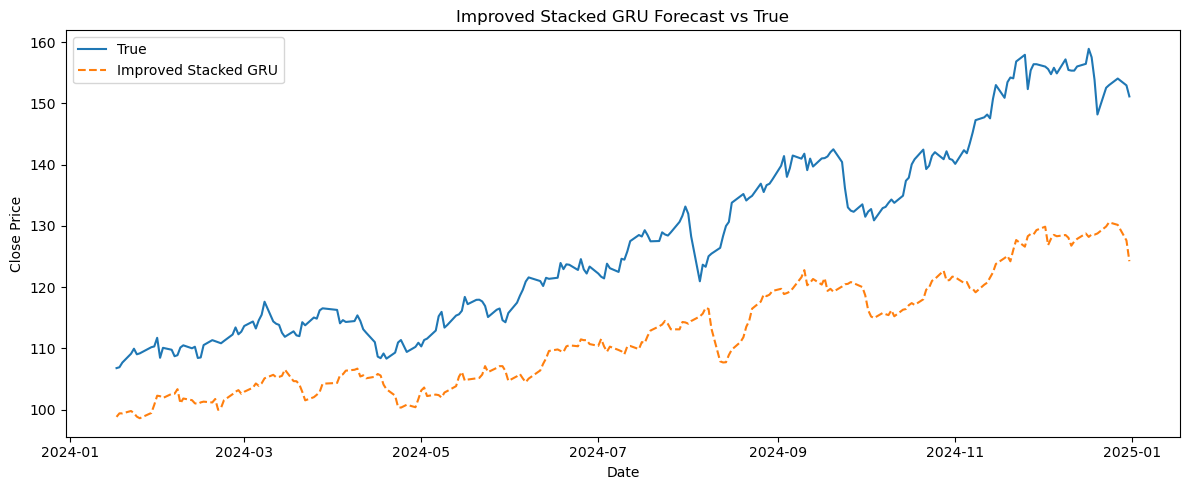

In [41]:
# Plot
plt.figure(figsize=(12, 5))
plt.plot(improved_index, improved_y_val, label='True')
plt.plot(improved_index, improved_y_pred, label='Improved Stacked GRU', linestyle='--')
plt.title('Improved Stacked GRU Forecast vs True')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

improved_gru_rmse = np.sqrt(mean_squared_error(improved_y_val, improved_y_pred))
improved_gru_mae = mean_absolute_error(improved_y_val, improved_y_pred)
improved_gru_mape = mean_absolute_percentage_error(improved_y_val, improved_y_pred)
improved_gru_r2 = r2_score(improved_y_val, improved_y_pred)

print("📊 Improved GRU Performance:")
print(f"RMSE: {improved_gru_rmse:.4f}")
print(f"MAE: {improved_gru_mae:.4f}")
print(f"MAPE: {improved_gru_mape:.4%}")
print(f"R² Score: {improved_gru_r2:.4f}")

📊 Improved GRU Performance:
RMSE: 16.9402
MAE: 15.5194
MAPE: 11.7446%
R² Score: -0.2589


#### 🔍 Why Performance Can Drop with Deeper GRU Models

- **Overfitting Risk**  
  More layers → More parameters → Higher chance of overfitting, especially with limited or noisy data.

- **Vanishing Gradients**  
  Even with GRUs, deeper RNNs can suffer from vanishing gradients, making it harder for early layers to learn.

- **Hyperparameter Sensitivity**  
  Deeper models are more sensitive to learning rate, dropout, and other hyperparameters. Default settings may not work well.

- **Information Dilution**  
  Stacking too many GRU layers can distort or bury important temporal patterns.

The 2-layer **Stacked GRU** showed the best performance — capturing meaningful patterns without overcomplicating the structure.  
  
**More depth ≠ better**. The optimal architecture depends on the data’s size, complexity, and noise level.

### 5-3. Comparison with Traditional Models

- Conduct quantitative comparisons with baseline models like Linear Regression or ARIMA.
- To ensure fairness, use the same feature set, same prediction target, and same window size across all models.

### Multivariate Linear Regression

In [43]:
from sklearn.linear_model import LinearRegression

📊 Multivariate Linear Regression Performance:
RMSE: 3.8458
MAE: 3.1353
MAPE: 2.42%
R² Score: 0.9362


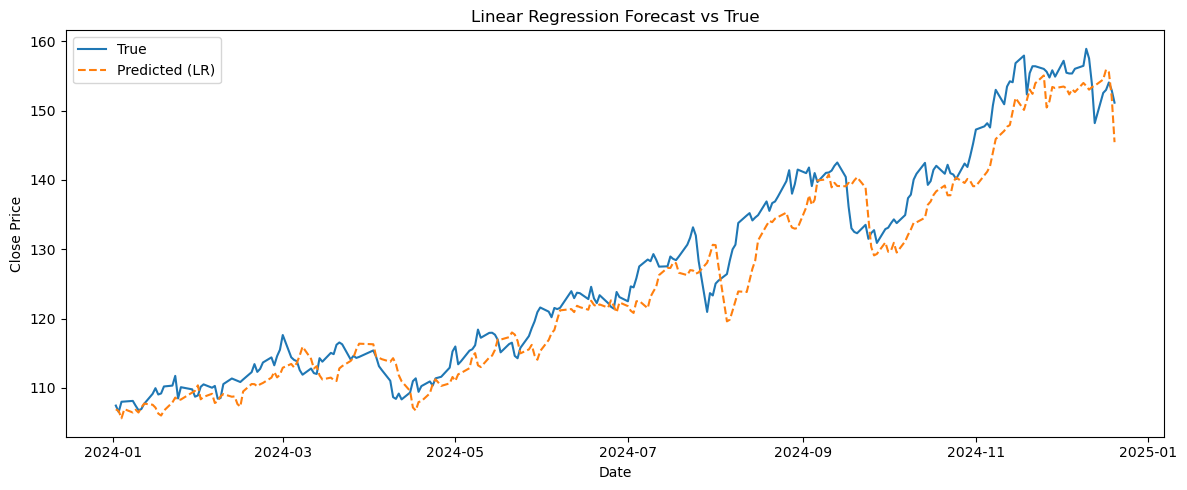

In [44]:
# Define features and target
lr_feature_cols = [
    'price_lag1', 'price_lag2', 'return_lag1',
    'SMA_5', 'SMA_20', 'EMA_20', 'RSI_14',
    'MACD', 'MACD_signal', 'roll_std5',
    'volatility_5', 'volatility_20', 'vol_ratio'
]
stock_df['next_5day_close'] = stock_df['Close'].shift(-5)
lr_target_col = 'next_5day_close'

# Drop missing values
data = stock_df.copy()
data = data.dropna(subset=lr_feature_cols + [lr_target_col])

# Split into train/test
lr_train_size = int(len(data) * 0.8)
lr_train, lr_test = data.iloc[:lr_train_size], data.iloc[lr_train_size:]

lr_X_train = lr_train[lr_feature_cols]
lr_X_test = lr_test[lr_feature_cols]
lr_y_train = lr_train[lr_target_col]
lr_y_test = lr_test[lr_target_col]

# Fit Linear Regression model
lr_model = LinearRegression()
lr_model.fit(lr_X_train, lr_y_train)

# Predict
lr_y_pred = lr_model.predict(lr_X_test)

# Evaluation
lr_rmse = np.sqrt(mean_squared_error(lr_y_test, lr_y_pred))
lr_mae = mean_absolute_error(lr_y_test, lr_y_pred)
lr_mape = mean_absolute_percentage_error(lr_y_test, lr_y_pred)
lr_r2 = r2_score(lr_y_test, lr_y_pred)

print("📊 Multivariate Linear Regression Performance:")
print(f"RMSE: {lr_rmse:.4f}")
print(f"MAE: {lr_mae:.4f}")
print(f"MAPE: {lr_mape:.2%}")
print(f"R² Score: {lr_r2:.4f}")

# Visualization
plt.figure(figsize=(12, 5))
plt.plot(lr_y_test.index, lr_y_test, label='True')
plt.plot(lr_y_test.index, lr_y_pred, label='Predicted (LR)', linestyle='--')
plt.title('Linear Regression Forecast vs True')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

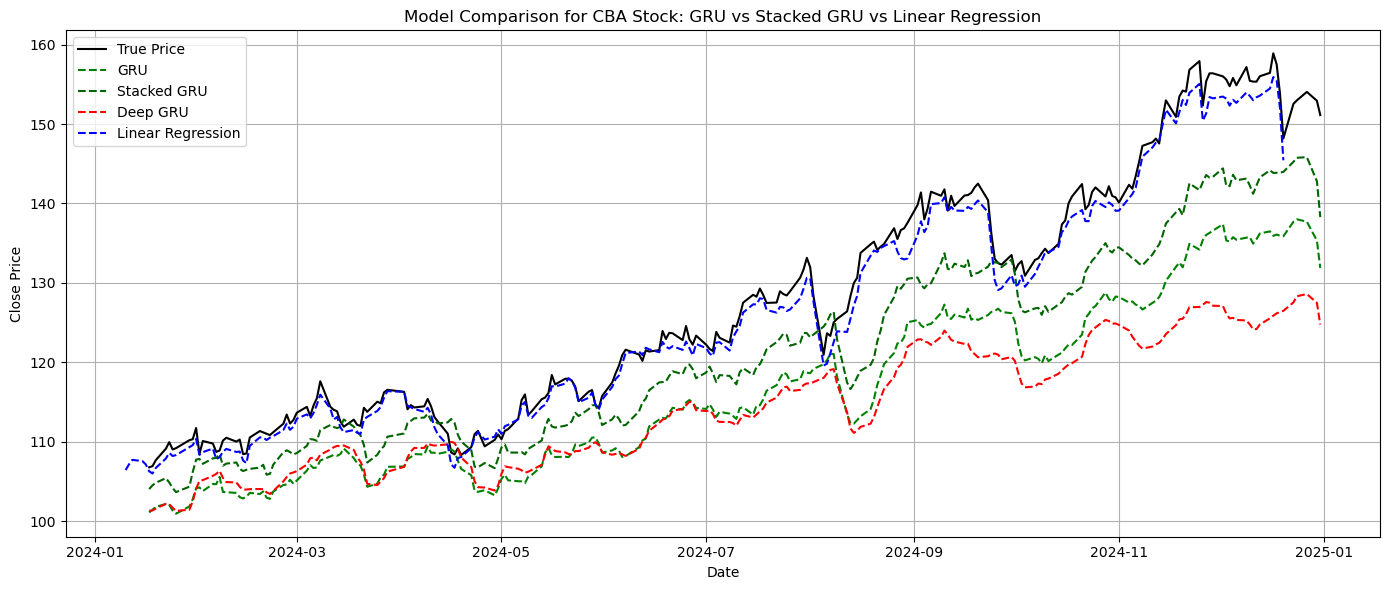

In [45]:
plt.figure(figsize=(14, 6))

# Actual closing
plt.plot(gru_index, gru_y_val, label='True Price', color='black')

# GRU
plt.plot(gru_index, gru_y_pred, label='GRU', linestyle='--', color='green')

# Stacked GRU
plt.plot(gru_index, stacked_y_pred, label='Stacked GRU', linestyle='--', color='darkgreen')

# Deep GRU
plt.plot(gru_index, deep_y_pred, label='Deep GRU', linestyle='--', color='red')

# Linear Regression
plt.plot(lr_y_test.index[-len(gru_index):], lr_y_pred[-len(gru_index):], label='Linear Regression', linestyle='--', color='blue')

# ARIMA
#plt.plot(arima_forecast.index[-len(gru_index):], arima_forecast[-len(gru_index):], label='ARIMA', linestyle='--', color='orange')

# Formatting
plt.title('Model Comparison for CBA Stock: GRU vs Stacked GRU vs Linear Regression')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### CBA Stock Performance

| Model               | RMSE    | MAE     | MAPE     | R² Score |
|--------------------|---------|---------|----------|----------|
| GRU                | 12.4425 | 11.2482 | 8.5051%  | 0.3209   |
| Stacked GRU        | 7.6508  | 6.4955  | 4.8651%  | 0.7432   |
| Deep GRU           | 15.5746 | 13.3168 | 9.8847%  | -0.0641  |
| Improved GRU       | 16.9402 | 15.5194 | 11.7446% | -0.2589  |
| Linear Regression  | 3.8458  | 3.1353  | 2.4200%  | 0.9362   |

**📝 Interpretation (CBA)**:
- The **Multivariate Linear Regression** model far outperformed all GRU-based models, with a very high **R² of 0.9362**, indicating excellent fit to the data.
- While **Stacked GRU** showed decent performance (**R² = 0.7432**), the **basic GRU**, **Deep GRU**, and **Improved GRU** models performed much worse.
- In particular, the **Deep** and **Improved GRU** models had **negative R²**, indicating poor generalization and overfitting.